In [2]:
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
orders = pd.read_csv('raw/006_lomo_orders_dataset.csv')
order_items = pd.read_csv('raw/007_lomo_order_items_dataset.csv')
sellers = pd.read_csv('raw/002_lomo_sellers_dataset.csv')
customers = pd.read_csv('raw/001_lomo_customers_dataset.csv')
geolocation = pd.read_csv('raw/003_lomo_geolocation_dataset.csv')

merged_df = pd.merge(orders, order_items, on='order_id', how='right')
merged_df = pd.merge(merged_df, sellers[['seller_id','seller_state']], on='seller_id', how='left')
merged_df = pd.merge(merged_df, customers[['customer_id','customer_state']], on='customer_id', how='left')

pd.DataFrame(merged_df)
print(merged_df.shape)

(112650, 16)


In [5]:
# Convert delivery date columns to datetime
merged_df['order_delivered_customer_date'] = pd.to_datetime(
    merged_df['order_delivered_customer_date'], format='%d/%m/%Y %H:%M', errors='coerce'
)
merged_df['order_delivered_carrier_date'] = pd.to_datetime(
    merged_df['order_delivered_carrier_date'], format='%d/%m/%Y %H:%M', errors='coerce'
)

# Keep only delivered orders
merged_df = merged_df[merged_df['order_status'] == 'delivered']

# Filter out rows where customer delivery date is before carrier date
merged_df = merged_df[merged_df['order_delivered_customer_date'] >= merged_df['order_delivered_carrier_date']]

print(merged_df.shape)
merged_df.head()

(110138, 16)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_state,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,delivered,13/09/2017 08:59,13/09/2017 09:45,2017-09-19 18:34:00,2017-09-20 23:43:00,29/09/2017 00:00,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,19/09/2017 09:45,58.90,13.29,Rayong,Yasothon
1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,delivered,26/04/2017 10:53,26/04/2017 11:05,2017-05-04 14:35:00,2017-05-12 16:04:00,15/05/2017 00:00,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,03/05/2017 11:05,239.90,19.93,Roi Et,Yasothon
2,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,delivered,14/01/2018 14:33,14/01/2018 14:48,2018-01-16 12:36:00,2018-01-22 13:19:00,05/02/2018 00:00,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,18/01/2018 14:48,199.00,17.87,Si Sa Ket,Saraburi
3,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,delivered,08/08/2018 10:00,08/08/2018 10:10,2018-08-10 13:28:00,2018-08-14 13:32:00,20/08/2018 00:00,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,15/08/2018 10:10,12.99,12.79,Si Sa Ket,Surin
4,00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,delivered,04/02/2017 13:57,04/02/2017 14:10,2017-02-16 09:46:00,2017-03-01 16:42:00,17/03/2017 00:00,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,13/02/2017 13:57,199.90,18.14,Mukdahan,Krabi


In [6]:
# Convert relevant columns to datetime
date_columns = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'shipping_limit_date'
]

for col in date_columns:
    merged_df[col] = pd.to_datetime(merged_df[col], errors='coerce', infer_datetime_format=True)

merged_df['purchase_to_delivery_days'] = (
    merged_df['order_delivered_customer_date'] - merged_df['order_purchase_timestamp']
).dt.days

merged_df['carrier_to_delivery_days'] = (
    merged_df['order_delivered_customer_date'] - merged_df['order_delivered_carrier_date']
).dt.days

# Check if order was delivered on or before estimated delivery date
merged_df['delivery_performance'] = merged_df.apply(
    lambda row: 'On Time' 
                if row['order_delivered_customer_date'] <= row['order_estimated_delivery_date'] 
                else 'Late',
    axis=1
)

# Check if carrier date was on or before shipping limit
merged_df['carrier_performance'] = merged_df.apply(
    lambda row: 'On Time'
                if row['order_delivered_carrier_date'] <= row['shipping_limit_date']
                else 'Late',
    axis=1
)

merged_df.head()

C:\Users\trust\AppData\Local\Temp\ipykernel_6896\1540547391.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  merged_df[col] = pd.to_datetime(merged_df[col], errors='coerce', infer_datetime_format=True)
C:\Users\trust\AppData\Local\Temp\ipykernel_6896\1540547391.py:12: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  merged_df[col] = pd.to_datetime(merged_df[col], errors='coerce', infer_datetime_format=True)
C:\Users\trust\AppData\Local\Temp\ipykernel_6896\1540547391.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/p

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_state,customer_state,purchase_to_delivery_days,carrier_to_delivery_days,delivery_performance,carrier_performance
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:00,2017-09-13 09:45:00,2017-09-19 18:34:00,2017-09-20 23:43:00,2017-09-29,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:00,58.90,13.29,Rayong,Yasothon,7,1,On Time,Late
1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:00,2017-04-26 11:05:00,2017-05-04 14:35:00,2017-05-12 16:04:00,2017-05-15,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:00,239.90,19.93,Roi Et,Yasothon,16,8,On Time,Late
2,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:00,2018-01-14 14:48:00,2018-01-16 12:36:00,2018-01-22 13:19:00,2018-02-05,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:00,199.00,17.87,Si Sa Ket,Saraburi,7,6,On Time,On Time
3,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:00,2018-08-08 10:10:00,2018-08-10 13:28:00,2018-08-14 13:32:00,2018-08-20,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:00,12.99,12.79,Si Sa Ket,Surin,6,4,On Time,On Time
4,00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:00,2017-02-04 14:10:00,2017-02-16 09:46:00,2017-03-01 16:42:00,2017-03-17,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:00,199.90,18.14,Mukdahan,Krabi,25,13,On Time,Late


In [7]:
# Remove rows with missing or invalid values
cleaned_df = merged_df.dropna(subset=['delivery_performance', 'carrier_performance'])

contingency_table = pd.crosstab(
    cleaned_df['delivery_performance'],
    cleaned_df['carrier_performance']
)

# Chi-squared test
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print("Chi-square statistic:", chi2)
print("p-value:", p_value)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

# The test reveals that p-value is 0, so we can reject the null hypothesis that the two variables are independent.
# This means that there is a statistically significant relationship between the delivery performance and carrier performance.

Chi-square statistic: 4093.734620237205
p-value: 0.0
Degrees of freedom: 1
Expected frequencies:
 [[  809.61014364  7903.38985636]
 [ 9424.38985636 92000.61014364]]


In [8]:
def sort_location_pair(cs, ss):
    sorted_pair = sorted([cs, ss])
    return sorted_pair[0], sorted_pair[1]

# Add columns for locationA and locationB
merged_df['locationA'], merged_df['locationB'] = zip(
    *merged_df.apply(lambda x: sort_location_pair(x['customer_state'], x['seller_state']), axis=1)
)

# Now group by these two location columns
aggregated_df = merged_df.groupby(['locationA', 'locationB']).agg(
    avg_purchase_to_delivery_days=('purchase_to_delivery_days', 'mean'),
    avg_carrier_to_delivery_days=('carrier_to_delivery_days', 'mean'),
    on_time_delivery=('delivery_performance', lambda x: (x == 'On Time').sum()),
    late_delivery=('delivery_performance', lambda x: (x == 'Late').sum()),
    on_time_carrier=('carrier_performance', lambda x: (x == 'On Time').sum()),
    late_carrier=('carrier_performance', lambda x: (x == 'Late').sum())
).reset_index()

# Calculate punctuality ratio
aggregated_df['punctuality_ratio'] = aggregated_df['on_time_delivery'] / (aggregated_df['on_time_delivery'] + aggregated_df['late_delivery'])
aggregated_df['total_successful_deliveries'] = aggregated_df['on_time_delivery'] + aggregated_df['late_delivery']

aggregated_df.head()

,locationA,locationB,avg_purchase_to_delivery_days,avg_carrier_to_delivery_days,on_time_delivery,late_delivery,on_time_carrier,late_carrier,punctuality_ratio,total_successful_deliveries
0,Amnat Charoen,Amnat Charoen,11.941176,8.235294,32,2,33,1,0.941176,34
1,Amnat Charoen,Ang Thong,8.441176,6.235294,32,2,33,1,0.941176,34
2,Amnat Charoen,Bangkok,10.909091,8.193182,78,10,80,8,0.886364,88
3,Amnat Charoen,Bueng Kan,13.425000,10.375000,34,6,32,8,0.850000,40
4,Amnat Charoen,Buri Ram,12.347826,9.293478,89,3,88,4,0.967391,92


In [9]:
aggregated_df.describe()

,avg_purchase_to_delivery_days,avg_carrier_to_delivery_days,on_time_delivery,late_delivery,on_time_carrier,late_carrier,punctuality_ratio,total_successful_deliveries
count,1964.000000,1964.000000,1964.000000,1964.000000,1964.000000,1964.000000,1964.000000,1964.000000
mean,11.685711,8.449611,51.642057,4.436354,50.867617,5.210794,0.924417,56.078411
std,2.994073,2.579842,92.178522,8.661549,91.267069,9.788979,0.086988,100.458896
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,10.116013,7.108333,9.000000,0.000000,9.000000,0.000000,0.896552,10.000000
50%,11.570598,8.367544,21.000000,2.000000,20.000000,2.000000,0.935484,23.000000
75%,13.020833,9.584052,55.000000,5.000000,54.000000,6.000000,1.000000,60.000000
max,40.000000,29.500000,1200.000000,97.000000,1187.000000,144.000000,1.000000,1297.000000


In [10]:
aggregated_df.to_csv('delivery_aggregated.csv', index=False)

In [11]:
# Calculate the 95th percentile of 'total_successful_deliveries', because there are too many orders to visualize
percentile_95 = aggregated_df['total_successful_deliveries'].quantile(0.95)

# Filter out rows where 'total_successful_deliveries' is below the mean
filtered_df = aggregated_df[aggregated_df['total_successful_deliveries'] >= percentile_95]

# Sort the filtered dataframe by 'punctuality_ratio' in ascending order
sorted_df = filtered_df.sort_values(by='punctuality_ratio', ascending=True)

sorted_df.head()

,locationA,locationB,avg_purchase_to_delivery_days,avg_carrier_to_delivery_days,on_time_delivery,late_delivery,on_time_carrier,late_carrier,punctuality_ratio,total_successful_deliveries
686,Chon Buri,Si Sa Ket,13.775641,10.185897,272,40,285,27,0.871795,312
1079,Lop Buri,Nakhon Ratchasima,12.058559,8.707207,194,28,196,26,0.873874,222
740,Kalasin,Maha Sarakham,12.899254,9.690299,235,33,231,37,0.876866,268
506,Chaiyaphum,Si Sa Ket,13.009153,9.292906,388,49,394,43,0.887872,437
368,Chachoengsao,Prachin Buri,13.536170,9.731915,209,26,209,26,0.889362,235


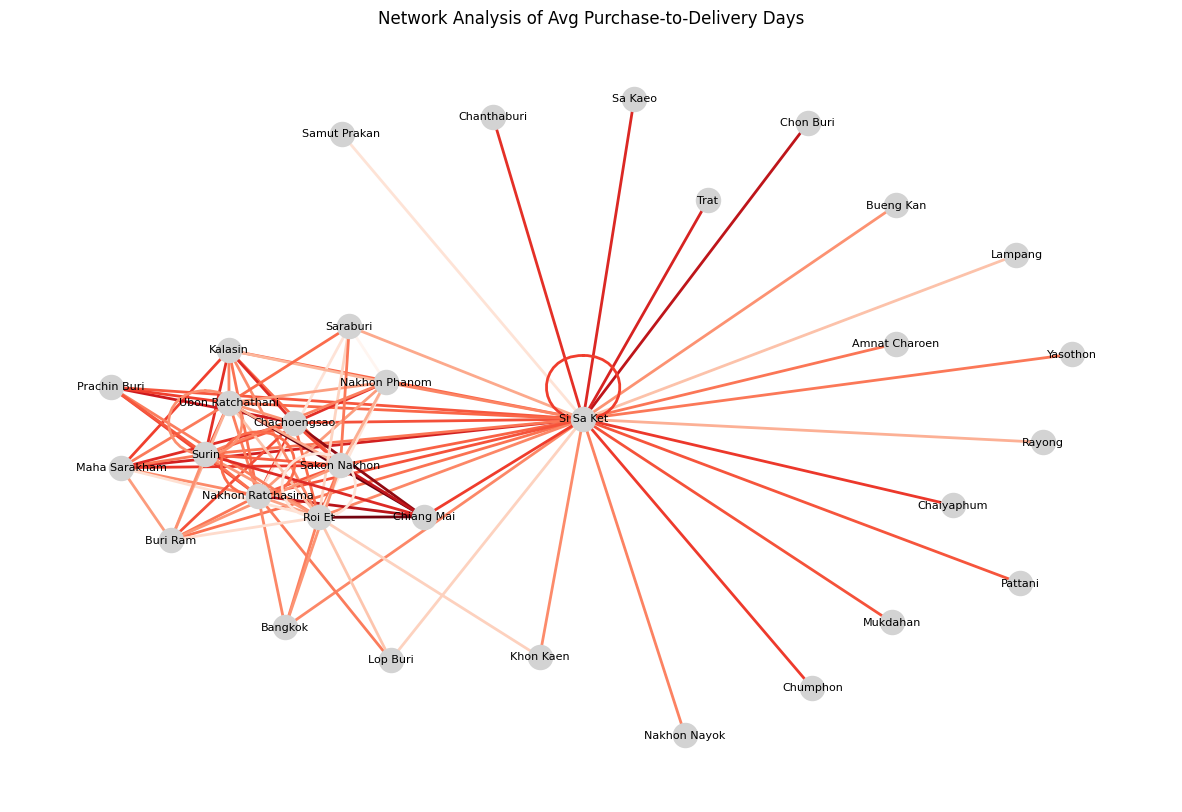

In [12]:
G = nx.from_pandas_edgelist(
    sorted_df, 
    source='locationA', 
    target='locationB', 
    edge_attr='avg_purchase_to_delivery_days'
)

pos = nx.spring_layout(G, seed=42)

values = [G[u][v]['avg_purchase_to_delivery_days'] for u, v in G.edges()]
norm = plt.Normalize(min(values), max(values))
colors = plt.cm.Reds(norm(values))

plt.figure(figsize=(15, 10))

nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightgray')
nx.draw_networkx_edges(G, pos, edge_color=colors, width=2)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Network Analysis of Avg Purchase-to-Delivery Days")
plt.axis('off')
plt.show()

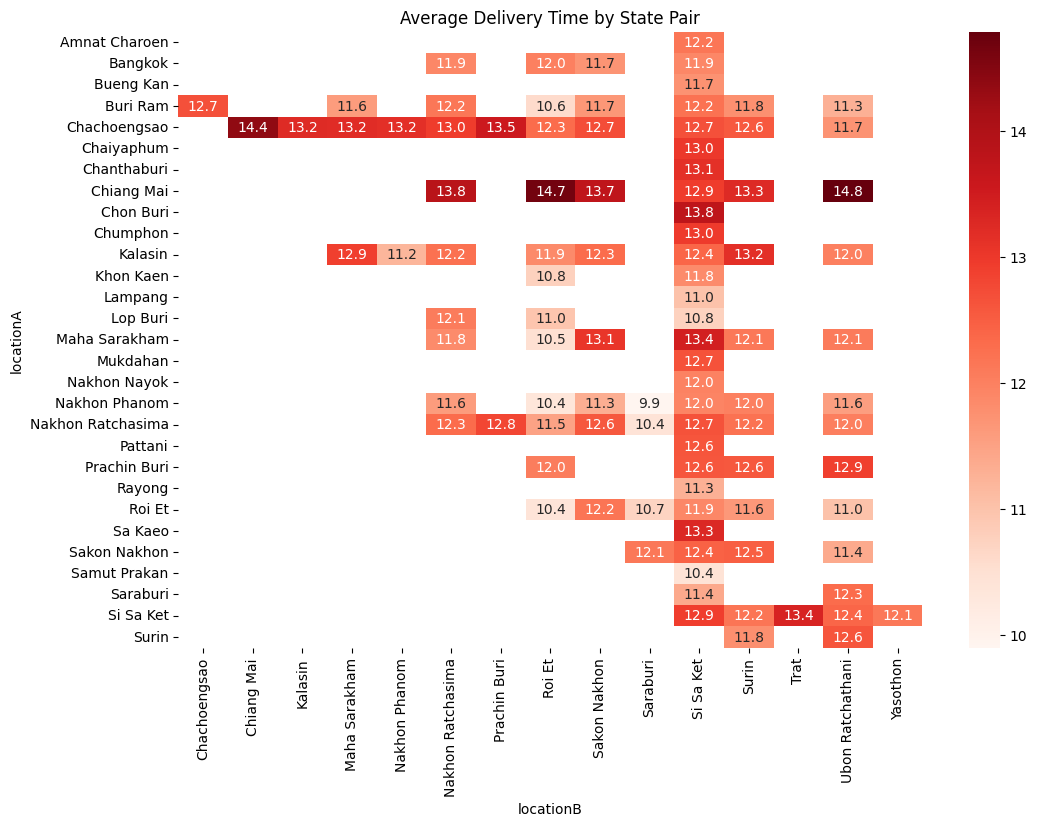

In [13]:
heatmap_df = sorted_df.pivot(
    index='locationA',
    columns='locationB',
    values='avg_purchase_to_delivery_days'
)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_df, cmap="Reds", annot=True, fmt=".1f")
plt.title("Average Delivery Time by State Pair")
plt.show()